# Mini Projet 2024 - à quoi tu ressembles sans ton masque ?

Avec la pandémie de la Covid-19, nous avons appris à porter des masques quotidiennement. 
Désormais la moitié de notre visage est cachée nous laissant le regard pour seul moyen d'expression visible. Cette opération de restaurer le visage s'apparente à un domaine en traitement d'images et de vidéos appelé **inpainting**. En effet, les pixels correspondant à la zone du masque (modélisé par un rectangle) sont mis à 0. Et l'ACP et les **eigenfaces** permettent, entre autres, de restaurer la zone dégradée.  


L'**objectif de ce mini projet** consiste à combler la zone de masque par un visage qui est le plus semblable à l'aide de l'ACP et des $k$ plus proches voisins.

In [61]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib import image
from random import *
from sklearn.metrics.pairwise import euclidean_distances

## Chargement des données

La base de données sur laquelle ce projet est appliqué est une collection d'images utiles pour mener des expériences en psychologie (*Psychological Image Collection at Stirling* (PICS) :http://pics.stir.ac.uk). 

<img src="./base.png" width="800" height="600"  >

Elle comporte 32 personnes (16 hommes et 16 femmes) avec 6 postures/expressions  faciales : 2 postures (face et trois quart face) et 3 émotions différentes par posture.



Text(0.5, 1.0, 'Exemple de visage')

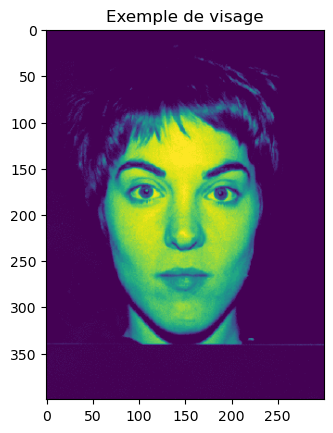

In [3]:
# Chargement des données de visages entiers : 192 x 120000
X_Data=np.load('../data/Data.npy')

# Dimensions des images
nblignes=400
nb_colonnes=300

plt.imshow(np.reshape(X_Data[0,:],(nblignes,nb_colonnes))) 
plt.title('Exemple de visage')

Text(0.5, 1.0, 'Exemple de visage masqué')

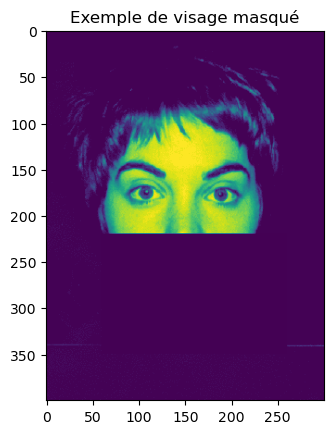

In [4]:
# Chargement des données de visages masqués : 192 x 120000
X_DataMask=np.load('../data/DataMask.npy')

plt.imshow(np.reshape(X_DataMask[0,:],(nblignes,nb_colonnes))) 
plt.title('Exemple de visage masqué')

# Création base d'apprentissage

(16, 120000)


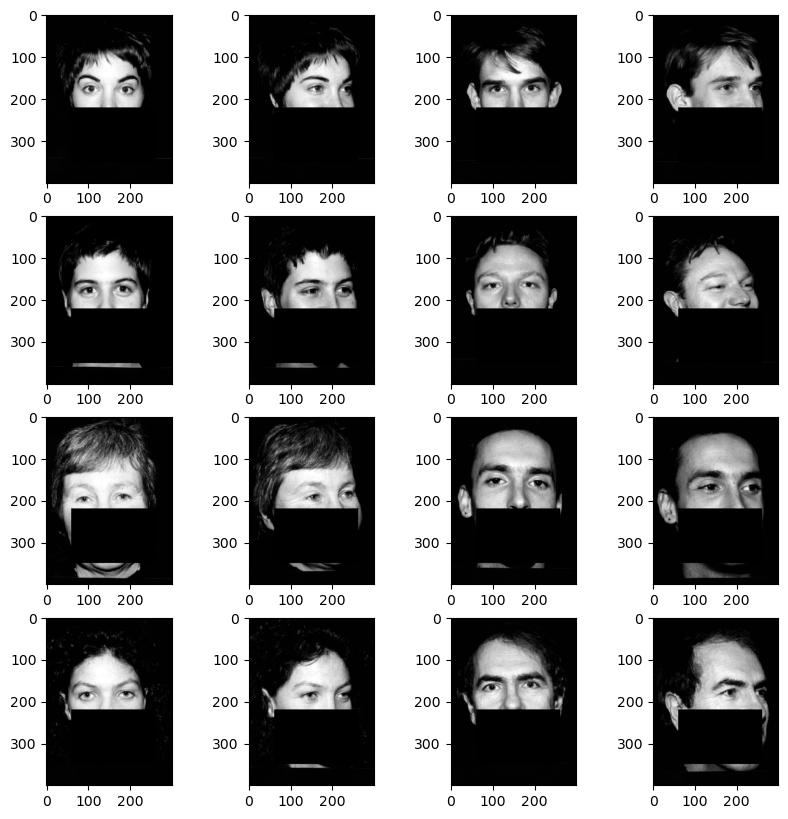

(16, 120000)


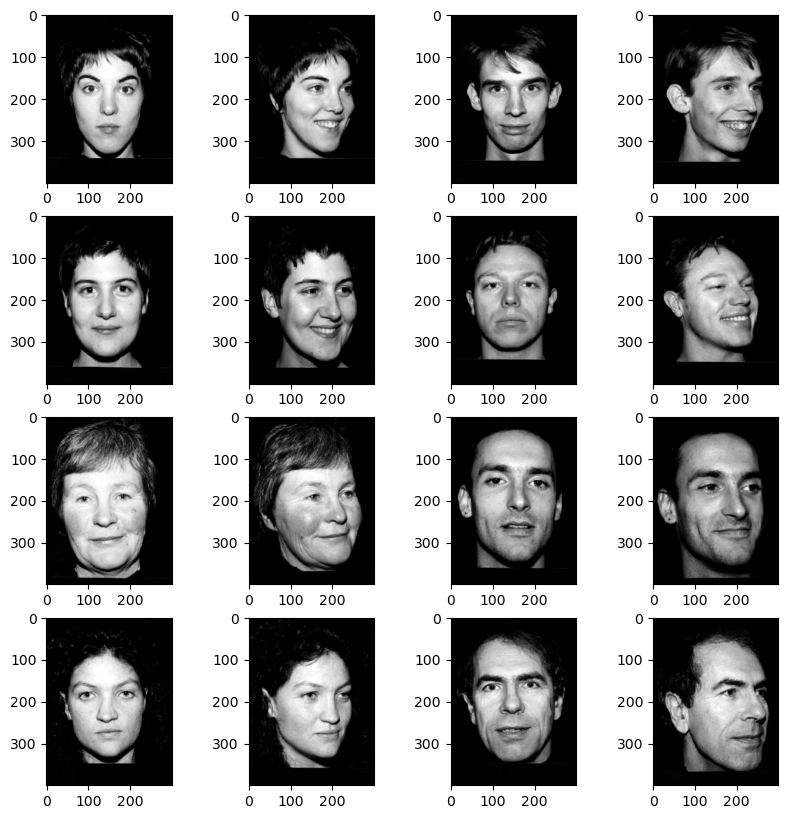

In [81]:
# Création de la base d'apprentissage : exemple à modifier
X_App=X_DataMask[np.arange(0,48,3),:] 

print(X_App.shape)

# Affichage des visages masqués de la base d'apprentissage
plt.figure(figsize=(10,10))
compt=0
for i in range(0,X_App.shape[0]):
    im=np.reshape(X_App[i,:],(400,300))
    plt.subplot(4,4,compt+1)
    compt=compt+1
    plt.imshow(im,cmap='gray')
    
plt.show()    


# Création de la base d'apprentissage : exemple à modifier
LabelApp=X_Data[np.arange(0,48,3),:] 

print(LabelApp.shape)

# Affichage des visages masqués de la base d'apprentissage
plt.figure(figsize=(10,10))
compt=0
for i in range(0,LabelApp.shape[0]):
    im=np.reshape(LabelApp[i,:],(400,300))
    plt.subplot(4,4,compt+1)
    compt=compt+1
    plt.imshow(im,cmap='gray')
    
plt.show()   


##  Eigenfaces et réduction de dimensions par ACP

Complétez la fonction *eigenfaces*, qui vise à calculer les axes
principaux des images d'apprentissage à partir des vecteurs propres associés
aux $n-1$ valeurs propres non nulles de la matrice de variance/covariance
$\Sigma$ des données/.


La notion d'eigenfaces provient du travail de M. Turk et A. Pentland intitulé «Eigenfaces for
Recognition» : https://www.mitpressjournals.org/doi/pdfplus/10.1162/jocn.1991.3.1.71 


<img src="./Eigenfaces.PNG" width="600" height="500"  >

**Remarque :**  la
    fonction *np.linalg.eig* ne peut pas être directement appliquée à $\Sigma$. En
    effet, sa taille $p\times p$ est gigantesque ($p = 120000$). Or, pour une
    matrice $\text{M}$ quelconque, $\text{M}^\top \text{M}$ et
    $\text{M}\,\text{M}^\top$ ont les mêmes valeurs propres \emph{non nulles}.
    On peut donc appliquer la fonction \verb!eig! à $\Sigma_2 = \text{X}_c \,
    \text{X}_c^\top/n$, de taille $n\times n$ beaucoup plus petite, pour
    calculer les valeurs propres non nulles de $\Sigma$.

(7, 120000)


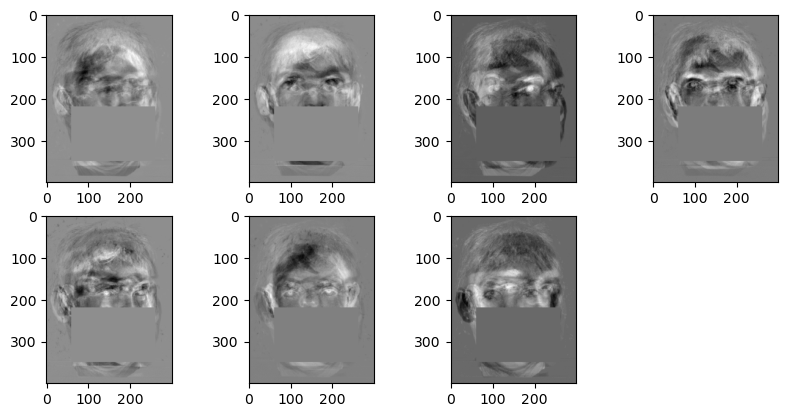

(7, 120000)


In [62]:
def eigenface(X_App,nb_component):
    # nb_component -> NOMBRE DE COMPOSANTE PRINCIPALE 
    # en terme de personne on pourrait partir sur m-1 et obtenir quand même des résultats pertinants
    # -> à tester 7 personnes au total
    sigma2 = np.cov(X_App)

    # tri des vecteurs propre dans l'ordre décroissant
    valp, eigvectors = np.linalg.eig(sigma2)

    indexes_valp = np.argsort(valp)[::-1] # tri dans l'odre décroissant des valeurs propres
    new_eigvectors = eigvectors[indexes_valp]

    #projection des vecteurs propres sur la matrice de jeu de donées
    mat = np.dot(new_eigvectors, X_App - np.mean(X_App, axis=0))
    # à tester sans le centrage des données pour les kppv
    # tester 

    #mat = mat[:7, :]
    print (mat.shape)

    plt.figure(figsize=(10,10))
    compt=0
    for i in range(0,mat.shape[0]):
        im=np.reshape(mat[i,:],(400,300))
        plt.subplot(4,4,compt+1)
        compt=compt+1
        plt.imshow(im,cmap='gray')
    plt.show()  

    return mat


print (eigenface(X_App, 3).shape)



## Reconnaissance par kppv

En tirant aléatoirement une image de test, parmi les 32 personnes et les 6 postures faciales disponibles dans la base de données complète, complétez une fonction pour trouver l'individu (personne+posture) et la distance du proche voisin dans la base d'apprentissage qui est le plus proche de l'image de test (vous pouvez utiliser et adapter la fonction \text{kppv} que vous avez écrite lors du TP2). 

[0.]
[6]


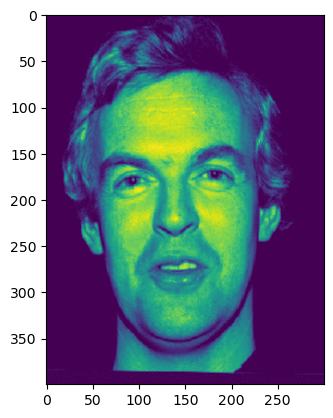

In [96]:
def kppv(DataApp, Image, LabelApp, K):

    # nb apprentissage
    Na = DataApp.shape[0]

    

    # Calcul des distances entre les vecteurs de test et les vecteurs d'apprentissage (voisins)
    dist_ij = np.zeros(Na)
    # for the test image we get the dist with all the elem of the DataApp
    dist_ij= euclidean_distances(Img.reshape(1,-1), DataApp)

    kneighbor = np.zeros(K)
    print (kneighbor)
    # On ne garde que les indices des K + proches voisins
    #sorting dist_ij by the nearest indices
    indices_dist_ij = np.argsort(dist_ij[0])

    # keep the k nearest elem of dist_ij
    #indice I have to use to get the LabelApp
    kneighbor = indices_dist_ij[:K]
    print(kneighbor)


    # Comptage du nombre de voisins appartenant a chaque classe
    
    #  classes = np.zeros(np.unique(LabelApp).shape[0])
    # print(classes)
    # for k in range(K):
    #     classes[int(LabelApp[kneighbor[k]])] += 1
    # print(classes)

    # Recherche de la classe contenant le maximum de voisins
    # Si l'image test a le plus grand nombre de voisins dans plusieurs
    # classes differentes,
    #     alors on lui assigne celle du voisin le + proche,
    # sinon on lui assigne l'unique classe contenant le plus de voisins
    # etiquette = np.argmax(classes)
    
    return kneighbor

seed()

# Visage tiré au hasard
rd = randint(0, X_Data.shape[0])
Img = X_Data[rd,:]
plt.imshow(np.reshape(Img,(nblignes,nb_colonnes))) 

# Plus proche voisin masqué
kneighbor= kppv(X_App, Img, LabelApp,1)



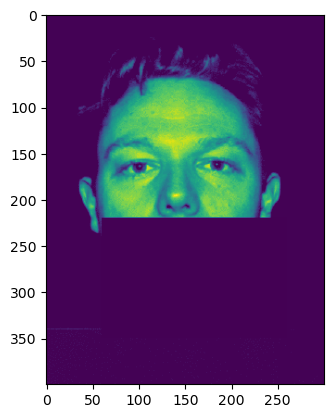

In [97]:
plt.imshow(np.reshape(X_App[kneighbor,:],(nblignes,nb_colonnes))) 


## Reconstruction 

A partir de la question précédente, implémentez la reconstruction de la zone du masque  en remplaçant la zone correspondant au masque par la zone de l'image de la base d'apprentissage de visages entiers la plus proche dans l'espace défini par les eigenfaces masqués.



In [9]:
# Dimensions du masque
ligne_min = 220
ligne_max = 350
colonne_min = 60
colonne_max = 260

# Evaluation

Pour l'évaluation, une possibilité serait d'estimer la distribution des distances au plus proche voisin dans le cas de la même personne avec une émotion différente et une posture différente.

En fonction de cette distribution, on peut définir une distance seuil à partir de laquelle on peut envoyer un message en précisant que 
-la personne la + proche n'est pas la bonne personne associée à l'image requête 

**Autre piste :** Affiner l'étude aussi lorsque la personne idenfiée correspond à l'image requête avec une autre distance spécifique pour une posture différente voire pour une émotion différente ? Plein de possiblités pour cette étude sur l'évaluation de la reconstruction.